### This notebook is used to update the figures used in the BMI1+ manuscript. The version of Python used here is 3.10.12 with scanpy 1.9.3.

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
import PlotGenerators as helper

import importlib
importlib.reload(helper)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scpy4reactome import pathway_analyzer as pa

DIR_NAME = '/Volumes/ssd/results/missy_sc_rna/bmi1/E15.5/'
figure_file_template = '{}manuscript_figures/{}.tiff'

Reactome_GMT_File = '../resources/MouseReactomePathways_Rel_75_122220.gmt'

In [ ]:
# Figure 5A: UMAP of the harmonized three time point data
# The following file was generated by another notebook, three_time_points_analysis.ipynb
filename = DIR_NAME + 'harmony_12_15_17_pan_cells_filtered_080823.h5ad'
adata_harmony = sc.read(filename)

In [ ]:
# The following color was set by Missy
# E12.5 FF8C00
# E12.5 stem FF6700
# E15.5 8A2BE2
# E15.5 stem 51087E
# E17.5 3F704D
# E17.5 stem 004225
adata_harmony.uns['batch_colors'] = ['#FF8C00', '#8A2BE2', '#3F704D']
plot = sc.pl.umap(adata_harmony, color='batch', show=False)
plot = helper.squarify_umap(plot, adata_harmony)
plt.savefig(figure_file_template.format(DIR_NAME, 'Fig5A'), bbox_inches='tight', dpi=495, facecolor='white')
del adata_harmony

In [44]:
%%script false --no-raise-error
# Fig 5D: UMAP colored with colors and CytoTRACE. Note: CytoTRACE was calculated by the Web Server.
# Generate a matrix of E15.5 to submit to the web server: https://cytotrace.stanford.edu. 
# To do this, the original raw counts are reloaded
# The following code was copied from Patric's bmi1-processing.py.
raw_count_dir_15_5 = DIR_NAME + '/aligned_outs/filtered_feature_bc_matrix'
adata_15_cytotrace = helper.open_data(raw_count_dir_15_5)
# Dump the counts
adata_15_cytotrace.X = adata_15_cytotrace.layers['counts']
adata_15_cytotrace_df = adata_15_cytotrace.to_df()
out_file_name = DIR_NAME + 'filtered_counts_e15_5.csv'
adata_15_cytotrace_df.transpose().to_csv(out_file_name)
del adata_15_cytotrace
del adata_15_cytotrace_df

In [45]:
# Output from the cytotrace web server was downaded as the following file
cytotrace_server_result_file = DIR_NAME + 'CytoTRACE_results_filtered_counts_e15_5.txt'
cyto_df = pd.read_csv(cytotrace_server_result_file, index_col=0, delimiter='\t')
cyto_df.index = cyto_df.index.str.replace('.','-')

# The processed adata is needed for merging
adata = sc.read_h5ad('../resources/adata_15_frozen.h5ad')
# cyto_df may have more cells
if adata.shape[0] != cyto_df.shape[0]:
    print('cytotrace and adata have different numbers of cells')
adata.obs['CytoTRACE'] = cyto_df['CytoTRACE']
# Get root cell
root_cell = cyto_df.CytoTRACE.idxmax()
print('Found root_cell: {}'.format(root_cell))
adata.uns['iroot'] = np.flatnonzero(adata.obs_names==root_cell)[0]

del cyto_df

cytotrace and adata have different numbers of cells
Found root_cell: ACTGATGGTCATCTAG-1


In [ ]:
# Plot UMAP colored with cluster and PAGA color by cytotrace
# The following code copied from figures.py
# UMAP with leiden cluster labeld
# adata = sc.read_h5ad('../resources/adata_15_frozen.h5ad')
testplots = [sc.pl.umap(adata, color='leiden', legend_loc='None', show=False), # No label
             sc.pl.umap(adata, color='leiden', legend_loc='on data', show=False, legend_fontweight='normal', legend_fontsize=12, legend_fontoutline=3)]
labels = ['no_label', 'with_label']
for i in range(len(labels)):
    label = labels[i]
    plot = testplots[i]
    plot = helper.squarify_umap(plot, adata)
    fig = plot.figure
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)
    plt.savefig(figure_file_template.format(DIR_NAME, 'Fig4D_' + label), bbox_inches='tight', dpi=600, facecolor='white')

In [51]:
# PAGA plot with cytotrace overlaid
def plot_paga(adata: sc.AnnData=adata,
              no_label: bool=True, 
              color: str='CytoTRACE',
              filename: str=figure_file_template.format(DIR_NAME, 'Fig4D_paga_cyto')):
    labels = None
    if no_label:
        labels = [''] * len(adata.obs['leiden'].unique())
    plot = sc.pl.paga(adata,
            #threshold=0.09,
            color = color,
            pos = adata.uns['paga']['pos'],
            cmap = 'viridis',
            root = adata.uns['iroot'],
            #fontsize=0,
            edge_width_scale=0.5,
            random_state=helper.random_state,
            labels=labels,
            fontoutline=1,
            fontweight='normal',
            fontsize=10,
            show=False)
    plot.set(adjustable='box', aspect='equal')
    cbar = plot.figure.properties()['default_bbox_extra_artists'][1]
    cbar.set_position((0.68,0.08,0.03,0.8)) # Manually determined
    fig = plot.figure

    # The following ticks are based on the previous UMAP and set manually
    plot.xaxis.set_ticks([-4, 0, 4, 8, 12])
    plot.xaxis.set_tick_params(reset=True, which='major', top=False)
    plot.yaxis.set_ticks([-4, 0, 4, 8, 12])
    plot.yaxis.set_tick_params(reset=True, which='major', right=False)

    # for i in range(14):
    #     fig.properties()['default_bbox_extra_artists'][3].set_visible(False) # se idx 3 for removing leiden text
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = plot.figure
    fig.set_canvas(new_manager.canvas)
    plt.savefig(filename, bbox_inches='tight', dpi=600, facecolor='white')

In [ ]:
plot_paga(no_label=True, filename=figure_file_template.format(DIR_NAME, 'Fig4E_paga_cyto_no_label'))
plot_paga(no_label=False, filename=figure_file_template.format(DIR_NAME, 'Fig4E_paga_cyto_label'))

Root cell: 634


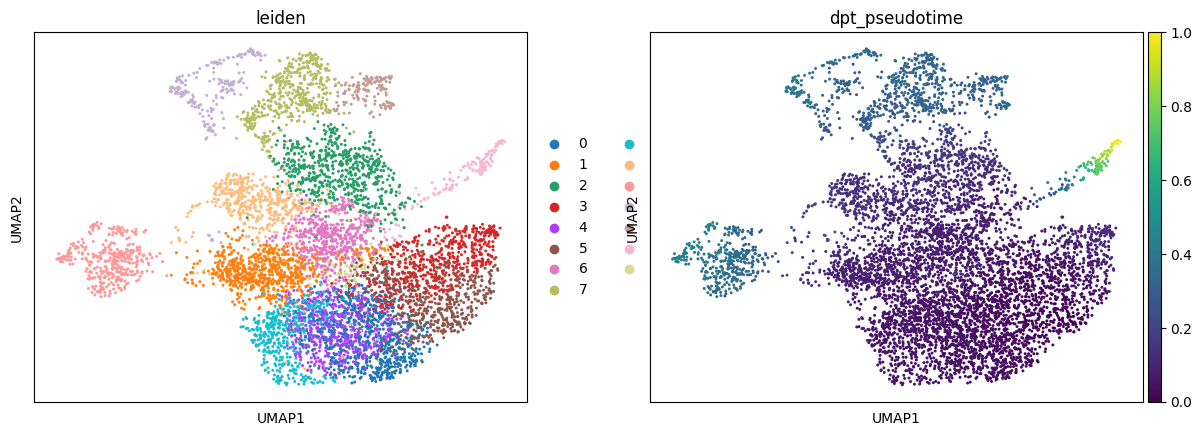

In [49]:
# Need dpt for Figure S5
iroot = adata.uns['iroot']
if iroot:
    print('Root cell: {}'.format(iroot))
else:
    raise ValueError('Cannot find iroot. Re-run cytotrace related cells.')
sc.tl.dpt(adata)
sc.pl.umap(adata, color=['leiden', 'dpt_pseudotime'])

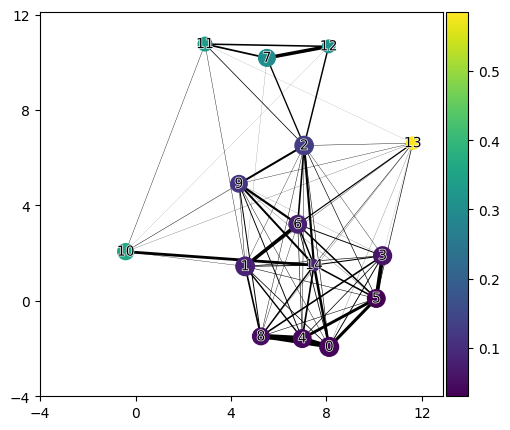

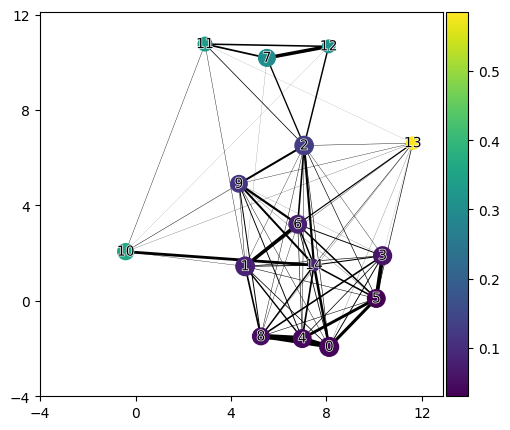

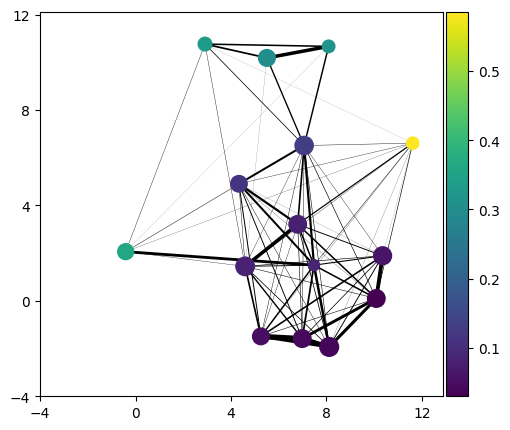

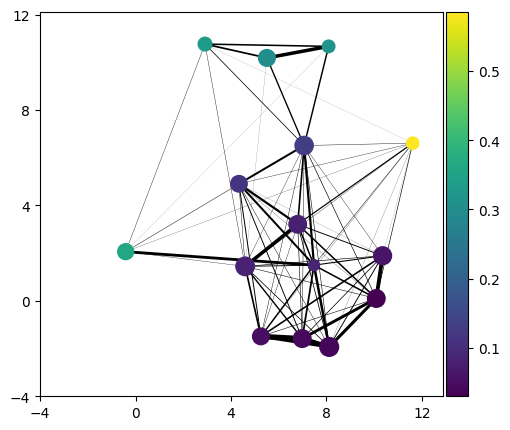

In [52]:
plot_paga(adata=adata, no_label=False, color='dpt_pseudotime', filename=figure_file_template.format(DIR_NAME, 'FigS5D_paga_dpt_label'))
plot_paga(adata=adata, no_label=True, color='dpt_pseudotime', filename=figure_file_template.format(DIR_NAME, 'FigS5D_paga_dpt_no_label'))

In [38]:
# Plot multiple UMAPs for genes and pathways
times = ['E12.5', 'E15.5', 'E17.5']
adata_files = ['../resources/adata_12_frozen.h5ad',
               '../resources/adata_15_frozen.h5ad',
               '../resources/adata_17_frozen.h5ad']
adatas = []
for adata_file in adata_files:
    adata = sc.read_h5ad(adata_file)
    adatas.append(adata)

In [39]:
def plot_multi_umaps(features: list,
                     figure_name: str,
                     times = times,
                     adatas = adatas):
    feature2max = {}
    for feature in features:
        gene_exp_list = [adata.obs_vector(feature).max() for adata in adatas if (feature in adata.var_names) or (feature in adata.obs_keys())]
        feature2max[feature] = max(gene_exp_list)

    for feature in features:
        for i in range(len(times)):
            time = times[i]
            adata = adatas[i]
            if (feature not in adata.var_names) and (feature not in adata.obs_keys()): # Defa24's case
                adata.obs[feature] = [0] * adata.shape[0]
            plot = sc.pl.umap(adata, color=feature, cmap='viridis_r', vmax=feature2max[feature], show=False)
            helper.squarify_umap(plot, adata)
            # cbar = plot.figure.properties()['default_bbox_extra_artists'][1]
            # cbar.set_position((0.85,0.70,0.5,0.5)) # Manually determined: left, bottom, width, and height.
            ax = plt.gca()
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            file_name = figure_file_template.format(DIR_NAME, figure_name + '_' + feature + "_" + time)
            plt.savefig(file_name, bbox_inches='tight', dpi=600, facecolor='white')
        # break

In [ ]:
# Fig 5F E15.5 for gene expression
# The following code copied from figures.py for easy visualization
# Neeed all three adata to set the same color scales for comparison
genes = ['Pou5f1', 'Alpi', 'Defa24', 'Chga', 'Wnt3', 'Wnt5a', 'Sfrp5', 'Dkk3']
plot_multi_umaps(genes, 'Fig5F')

In [40]:
# To plot pathways, we need to make sure pathways activities are there
def ensure_pathway(pathways, adatas=adata):
    for adata in adatas:
        pathway_df = adata.obsm[pa.AUCELL_KEY] # This is a dataframe with pathway names as columns
        for pathway in pathways:
            if pathway in pathway_df.columns:
                adata.obs[pathway] = pathway_df[pathway]
            else:
                adata.obs[pathway] = 0

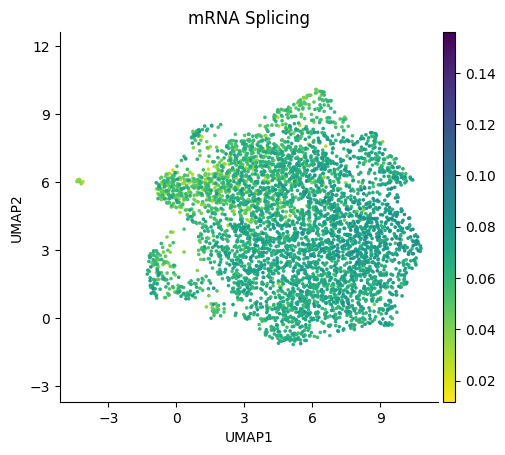

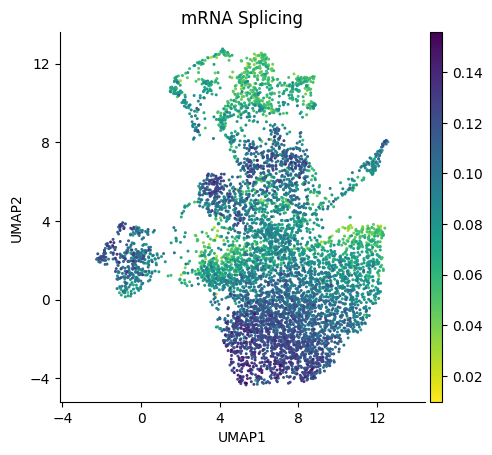

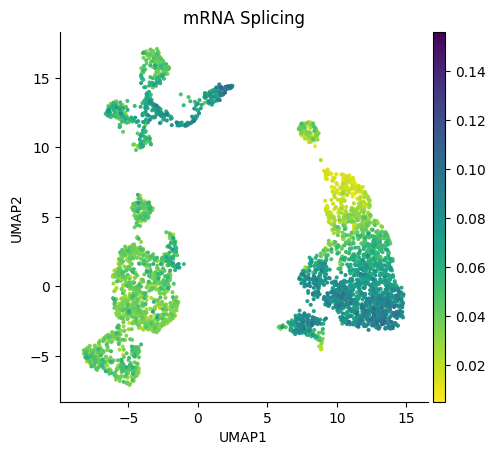

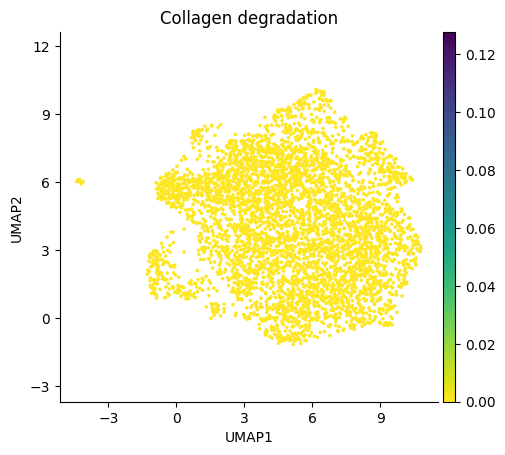

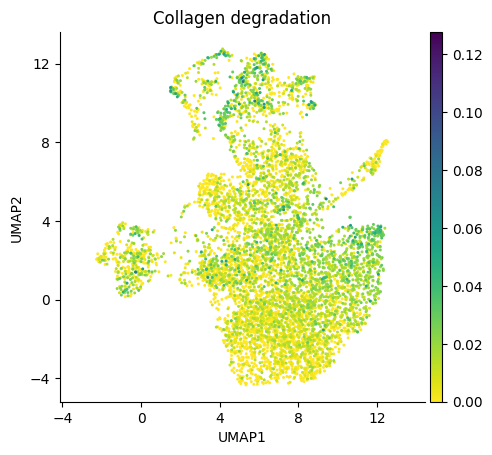

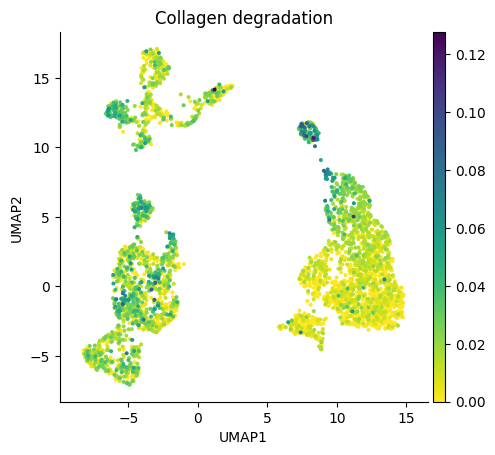

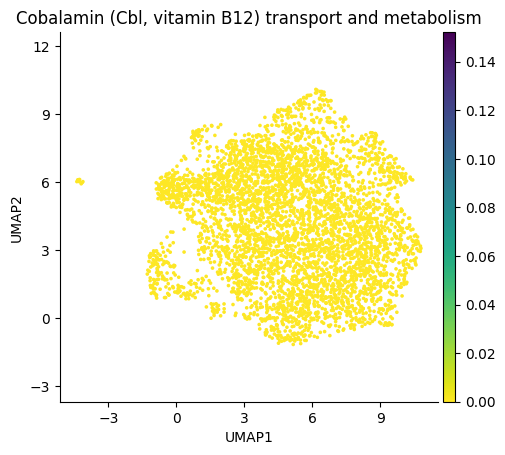

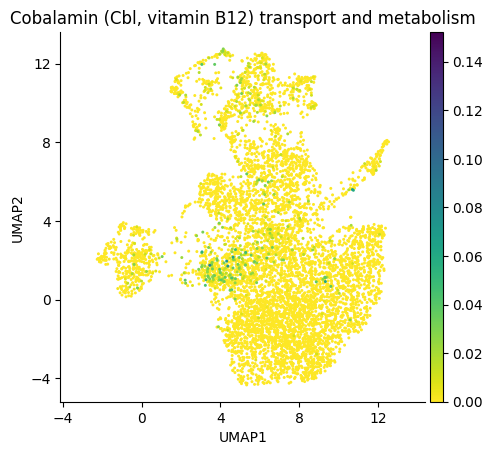

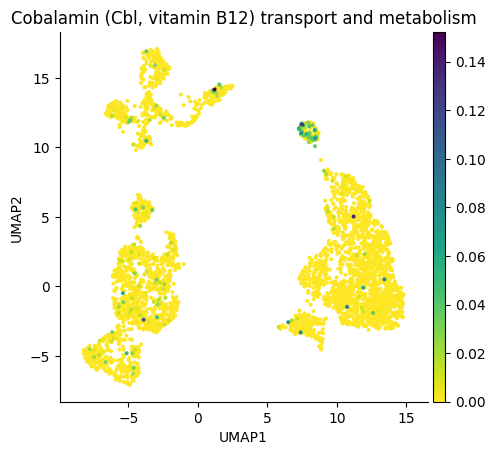

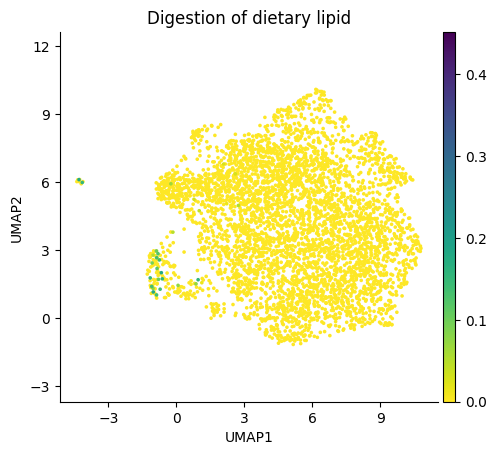

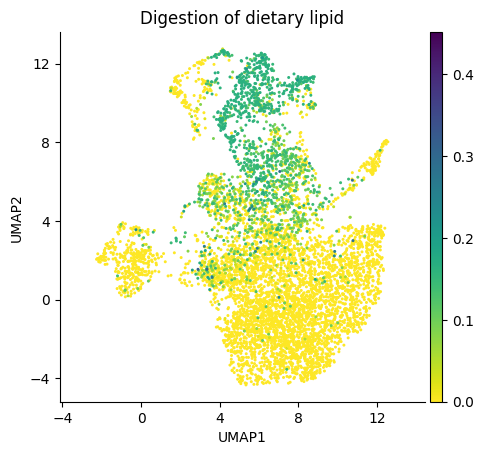

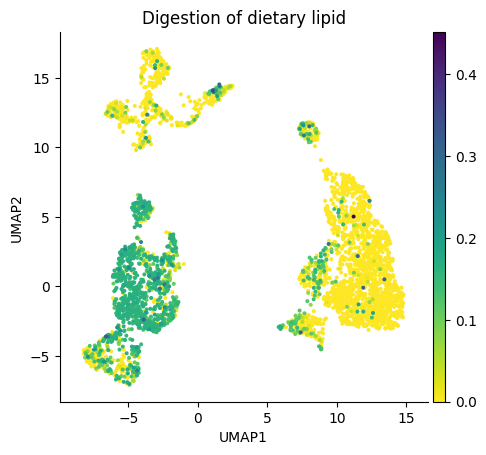

In [41]:
# Pathway Activity Plot
# The following pathways are for Fig 5G
fig5g_pathways = [
    'mRNA Splicing', 
    'Collagen degradation', 
    'Cobalamin (Cbl, vitamin B12) transport and metabolism', 
    'Digestion of dietary lipid']
ensure_pathway(fig5g_pathways, adatas)
plot_multi_umaps(fig5g_pathways, 'Fig5G')

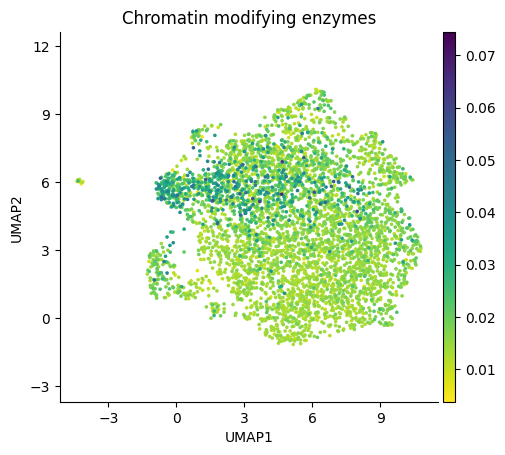

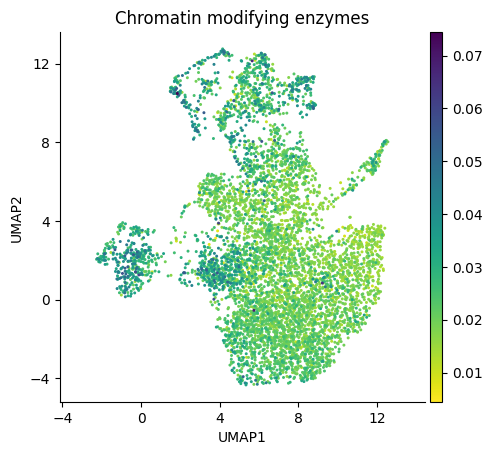

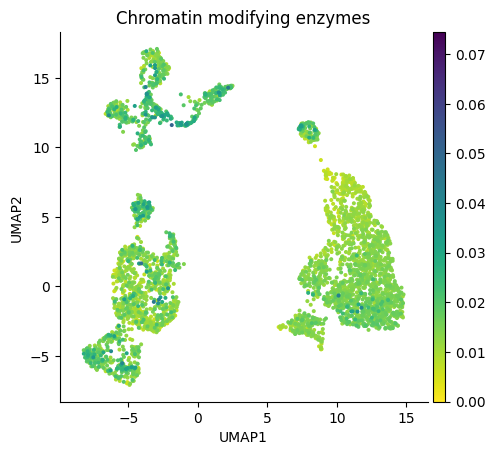

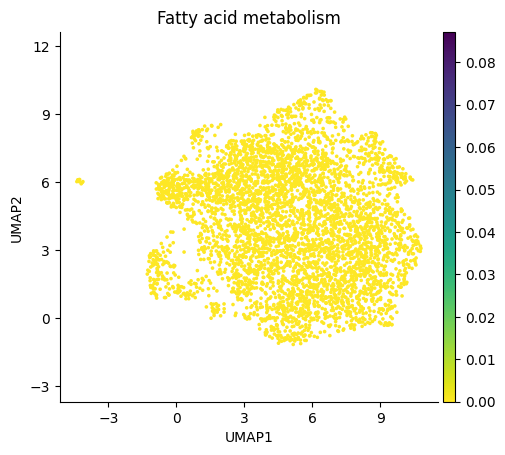

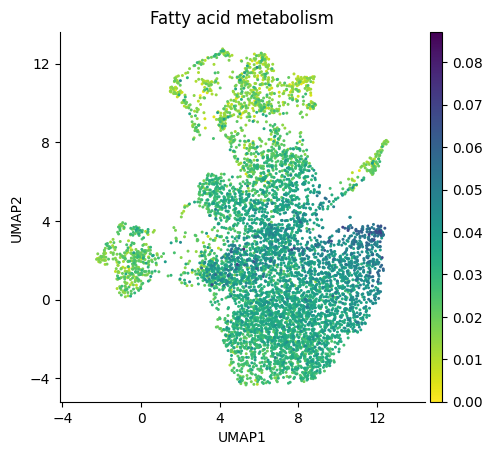

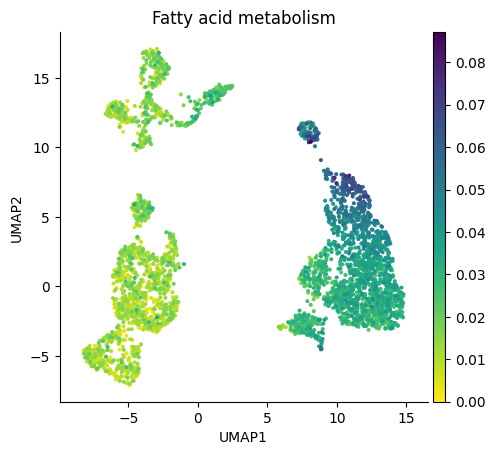

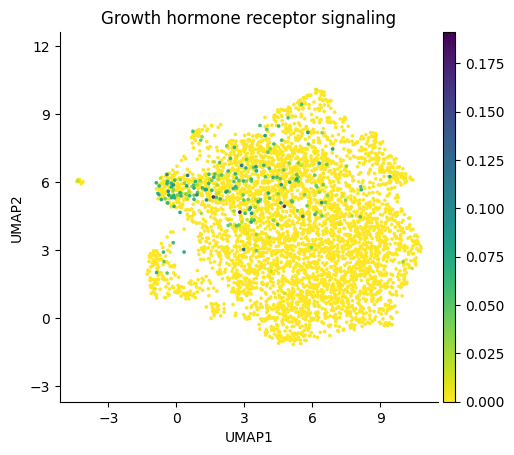

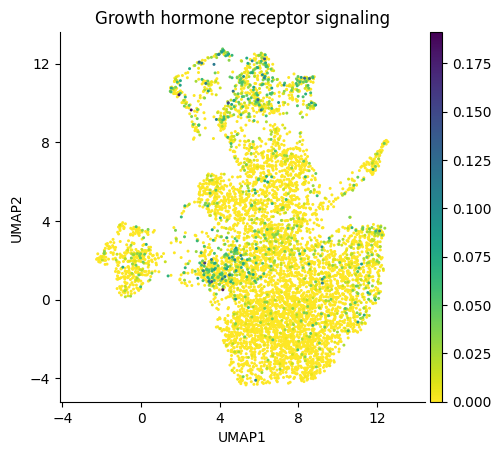

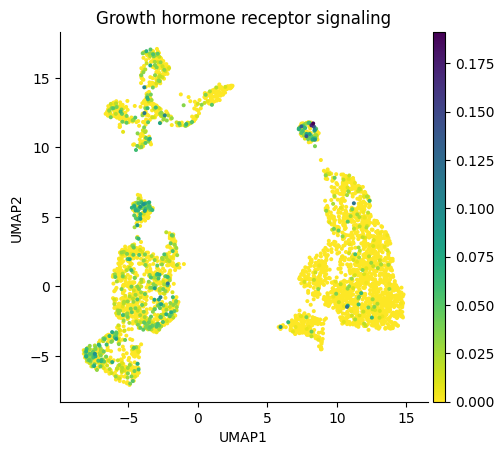

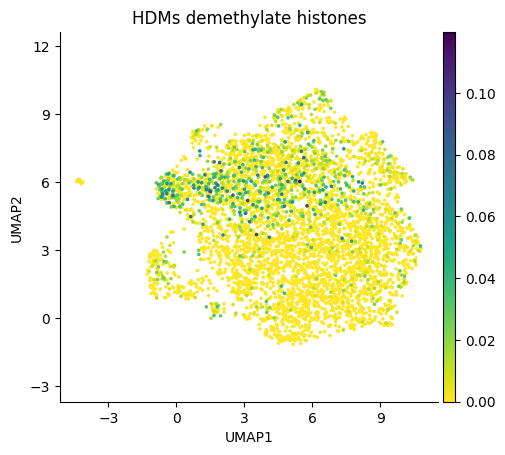

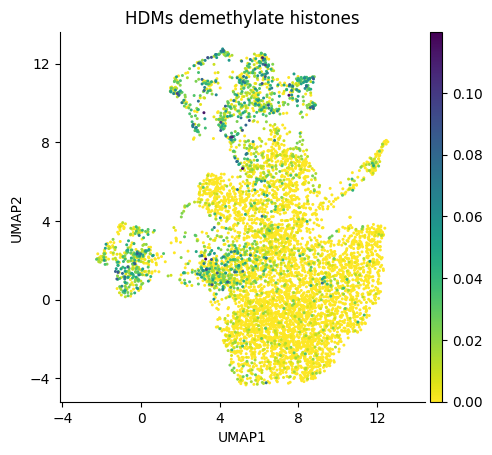

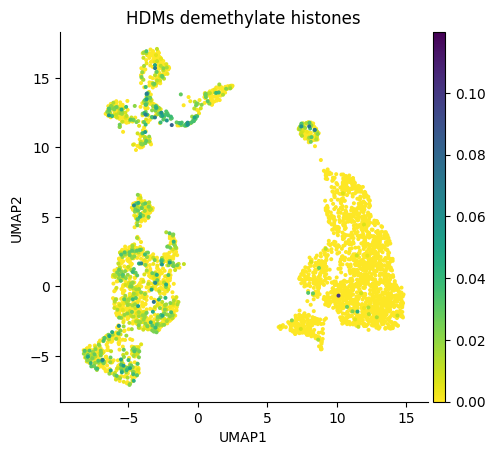

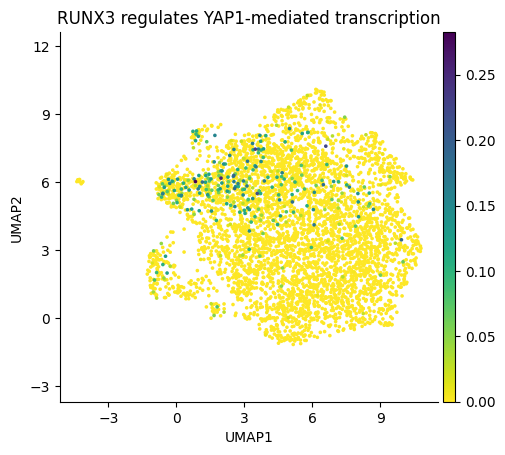

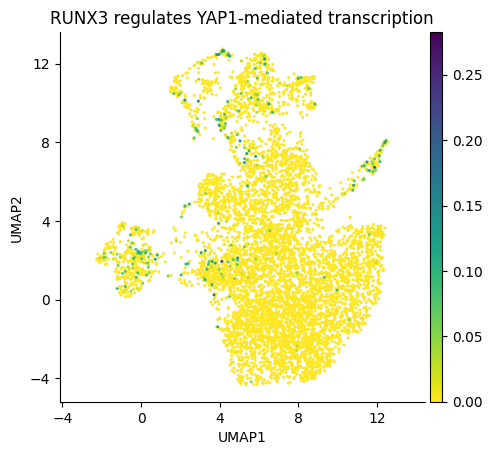

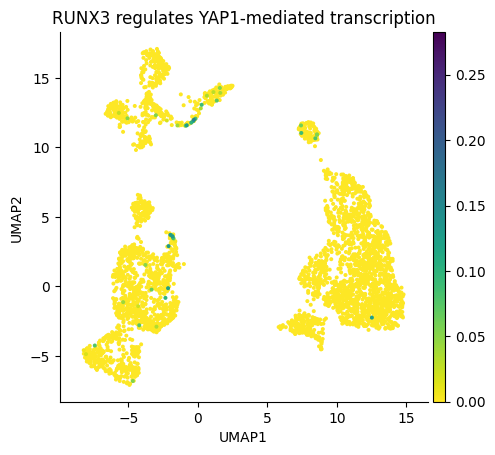

In [43]:
# The following pathways are for Fig S5
figS5_pathways = [
    'Chromatin modifying enzymes',
    'Fatty acid metabolism', 
    'Growth hormone receptor signaling', 
    'HDMs demethylate histones', 
    'RUNX3 regulates YAP1-mediated transcription'
]
ensure_pathway(figS5_pathways, adatas)
plot_multi_umaps(figS5_pathways, 'FigS5')

In [ ]:
for adata in adatas:
    del adata

In [37]:
%%script false --no-raise-error # Escape this cell when running the whole notebook. This cell needs to be run only once.
# Perform Pathway Analysis for E15.5
# Note: This frozen file may be different from the file used for pathway plot. Check it first.
# This cell should be run only once.
adata_file_name_src = DIR_NAME + '07232023_Remove_Pan_Cells/processed_filtered_pan_cells_072623.h5ad'
adata = sc.read_h5ad(adata_file_name_src)
# pa_result = pa.reactome_aucell(adata, Reactome_GMT_File)
# Apparently the original pathway results for E12.5 and E17.5 are not scaled. The new version of pathway_analyser
# uses scaling. To keep with the old results, therefore, use the code there to not scale.
aucell_wrapper = pa.AUCellWrapper()
aucell_wrapper.aucell(adata,
                      Reactome_GMT_File,
                      pa.AUCELL_KEY,
                      filter_with_max_score=1.0E-4, # Default with 0.0001,
                      need_plot=False,
                      need_scale=False)
# Save the result into a new h5ad file so that there is no need to re-calculate it though it is not that slow.
adata_file_name = DIR_NAME + '07232023_Remove_Pan_Cells/processed_filtered_pan_cells_072623_pathway_082523.h5ad'
adata.write_h5ad(adata_file_name)
del adata

Less than 80% of the genes in 5-Phosphoribose 1-diphosphate biosynthesis are present in the expression matrix.
Less than 80% of the genes in Eicosanoids are present in the expression matrix.
Less than 80% of the genes in ABO blood group biosynthesis are present in the expression matrix.
Less than 80% of the genes in Acetylation are present in the expression matrix.
Less than 80% of the genes in Acetylcholine binding and downstream events are present in the expression matrix.
Less than 80% of the genes in Acrosome Reaction and Sperm:Oocyte Membrane Binding are present in the expression matrix.
Less than 80% of the genes in Activated NTRK2 signals through PLCG1 are present in the expression matrix.
Less than 80% of the genes in Activated PKN1 stimulates transcription of AR (androgen receptor) regulated genes KLK2 and KLK3 are present in the expression matrix.
Less than 80% of the genes in Activation of AMPA receptors are present in the expression matrix.
Less than 80% of the genes in Act